In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

In [4]:
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
import sys, os
import dill
sys.path.append('../')
import mg_si
import csv
import datetime
from mg_si import plot as mplt


In [5]:
import matplotlib as mpl
import matplotlib.path as mplPath
import matplotlib.patches as patches
from matplotlib import gridspec

def remove_outliers(t,y,percent=0.3, N=3):
    Nends = N-1
    yo = y + np.mean(y)*.1
    if np.isclose(np.mean(yo),0.):
        return t,np.zeros_like(y)
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((yo[:-Nends]+yo[Nends:])/(2*yo[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

# Plotting


In [6]:
cnames = ['FeO','MgO','SiO2','cooling']
Myrs = 365.25*24*3600*1e6

def get_color(cname):
    cnames = ['FeO','MgO','SiO2','cooling']
    coolcolor = (1,0,0,1)
    scolor = (0.2, 0.6274509803921569, 0.17254901960784313,1)
    fcolor  = (0.7294117647058823, 0.3333333333333333, 0.8274509803921568,1)
    mcolor = (0.0, 0.7490196078431373, 1.0,1)
    colors = [fcolor,mcolor,scolor, coolcolor]
    return colors[cnames.index(cname)]

def maxE_color(df, cvar='maxE'):
    cvals = df[cvar].fillna('FeO')
    colors = np.array([get_color(v) for v in cvals])
    if df[cvar].isnull().any():
        colors[df[cvar].isnull()] = (1,1,1,0)    
    return colors

def df_color(df, cvar = 'T_cmb0'):
    mi = np.min(df[cvar])
    cvals = (df[cvar]-mi)/(np.max(df[cvar])-mi)
    colors= plt.cm.rainbow(cvals)
    return colors

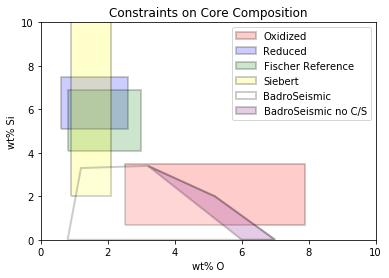

In [7]:
FischerOxidizedPath = mplPath.Path(np.array([(2.5,.7),(2.5,3.5),(7.9,3.5),(7.9,.7),(2.5,.7)]))
FischerReducedPath = mplPath.Path(np.array([(.6,5.1),(.6,7.5),(2.6,7.5),(2.6,5.1),(.6,5.1)]))
FischerReferencePath = mplPath.Path(np.array([(.8,4.1),(3,4.1),(3,6.9),(.8,6.9),(.8,4.1)]))

SiebertOSiPath = mplPath.Path(np.array([(.9,2),(2.1,2),(2.1,13),(.9,13),(.9,2)]))

BadroSeismicOSiPath = mplPath.Path(np.array([[0.8, 0. ],
       [1.2, 3.3],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[0.8, 0. ]]), None)
BadroSeismicOSinoCSPath = mplPath.Path(np.array([[6, 0. ],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ],[6, 0. ]]), None)
plt.figure()
ax = plt.subplot(111)
patch = patches.PathPatch(FischerOxidizedPath, lw=2., facecolor='red',alpha=.2,label='Oxidized')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Fischer Reference')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., facecolor='yellow', alpha=.2,label='Siebert')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSiPath, lw=2., facecolor='white', alpha=.2,label='BadroSeismic')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, lw=2., facecolor='purple', alpha=.2,label='BadroSeismic no C/S')
ax.add_patch(patch)
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.title('Constraints on Core Composition')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.savefig('core constraints.pdf')

In [8]:
c = mg_si.reactions.Core_All()
cb = mg_si.reactions.Core_MgSi()
wtp_Ni = .05

def convert_wtp_s_in_df(df,wtp_Ni=.05,inplace=False):
    if not inplace:
        df = df.copy()
    wt2conv = np.zeros((len(c.molmass)))
    wt2conv[5] = wtp_Ni
    for i,row in df.iterrows():
        wtp_Mg = row['wt_Mg_p']
        wtp_Si = row['wt_Si_p']
        wtp_Fe = row['wt_Fe_p']
        wtp_O = row['wt_O_p']
        wtp0 = np.array([wtp_Mg, wtp_Si, wtp_Fe, wtp_O])/100.
        wtp_n = cb.wtp2wt(wtp0,wt_tot=1-wtp_Ni)
#         wt2conv[:4] = wtbv
#         wtp_n = c.wt2wtp(wt2conv)
        df.loc[i,'wt_Mg_p'] = wtp_n[0]*100
        df.loc[i,'wt_Si_p'] = wtp_n[1]*100
        df.loc[i,'wt_Fe_p'] = wtp_n[2]*100
        df.loc[i,'wt_O_p'] = wtp_n[3]*100
        
        wtp_Mg = row['wt_Mg_0']
        wtp_Si = row['wt_Si_0']
        wtp_Fe = row['wt_Fe_0']
        wtp_O = row['wt_O_0']
        wtp0 = np.array([wtp_Mg, wtp_Si, wtp_Fe, wtp_O])/100.
        wtp_n = cb.wtp2wt(wtp0,wt_tot=1-wtp_Ni)
#         wt2conv[:4] = wtbv
#         wtp_n = c.wt2wtp(wt2conv)
        df.loc[i,'wt_Mg_0'] = wtp_n[0]*100
        df.loc[i,'wt_Si_0'] = wtp_n[1]*100
        df.loc[i,'wt_Fe_0'] = wtp_n[2]*100
        df.loc[i,'wt_O_0'] = wtp_n[3]*100
    return


In [9]:
datadir = '/media/nknezek/compute_storage/explore_space_test/'
df10 = dill.load(open('dataframe_r10_allcomputed_Fischer.m','rb'))
solutionfile = 'data.m'
alldatafile = 'all_parameters.m'

convert_wtp_s_in_df(df10,inplace=True)

df10 = df10[df10['wt_Mg_0']<=2]
df10 = df10[df10['wt_O_0']<20]
df10 = df10[df10['wt_Si_0']<20]
df10.describe()


,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,wt_Mg_p,wt_Si_p,wt_Fe_p,wt_O_p,wt_MgO_p,...,i_ic,t_ic,dE_ic,E_MgO_t,E_FeO_t,E_SiO2_t,E_ex_t,E_s_t,ex_s_rat,ex_s_diff
count,3.517000e+03,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,...,3517.000000,3.517000e+03,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000,3517.000000
mean,1.225079e+06,5749.274950,0.018163,0.131655,0.193290,0.137402,7.592901,81.693510,5.576187,18.987532,...,35330.753483,1.275297e+17,1.189074,197.336985,39.881216,467.730207,704.948408,514.611732,1.408325,0.140718
std,6.947700e+04,170.132327,0.010660,0.087345,0.094752,0.221446,5.674994,6.069039,3.748012,20.309931,...,1194.305324,2.403686e+15,0.672137,164.905504,57.430173,166.704034,166.762356,47.751108,0.464773,0.154674
min,1.098070e+06,5300.000000,0.000000,0.000000,0.050000,0.000550,0.000512,67.535291,0.485981,0.657379,...,17244.000000,1.218430e+17,-3.582483,0.000000,0.000000,0.000000,204.087221,383.027592,0.346684,-0.485129
25%,1.167657e+06,5600.000000,0.010000,0.060000,0.100000,0.009171,2.788106,77.337452,2.009181,3.050072,...,34832.000000,1.255622e+17,0.734174,65.875982,1.075711,410.316204,601.619333,476.586863,1.098936,0.047136
50%,1.227537e+06,5800.000000,0.020000,0.120000,0.200000,0.035844,6.385881,81.494177,5.148622,9.024504,...,35400.000000,1.275805e+17,1.138557,163.235088,15.653735,488.074346,679.093006,527.920067,1.285137,0.124779
75%,1.283699e+06,5900.000000,0.030000,0.200000,0.260000,0.166023,12.105091,86.723401,8.187848,30.764953,...,35928.000000,1.294834e+17,1.483996,294.391511,54.235559,551.303246,801.751034,555.702890,1.643096,0.243312
max,1.341927e+06,6000.000000,0.040000,0.330000,0.400000,1.284933,19.823944,93.644351,15.449123,87.143430,...,36720.000000,1.323377e+17,16.690227,847.537576,371.224576,1174.048805,1482.623340,588.767821,3.870800,0.589390


# Plot inner-core dependence

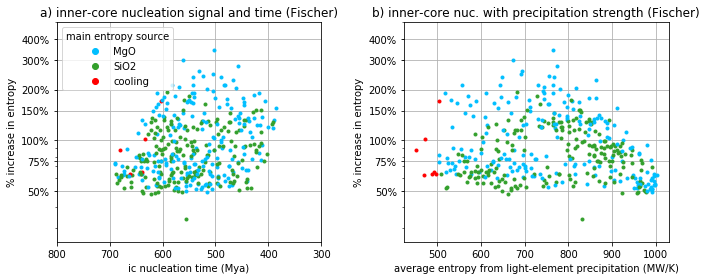

In [11]:
df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


plt.figure(figsize=(10,4))
plt.subplot(121)


lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(4560-df['t_ic']/Myrs,df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('ic nucleation time (Mya)')
plt.ylabel('% increase in entropy')
plt.title('a) inner-core nucleation signal and time (Fischer)')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)
plt.xlim(800,300)
plt.legend(handles=lpatchs[1:], title='main entropy source',)


plt.subplot(122)

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('b) inner-core nuc. with precipitation strength (Fischer)')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)


plt.tight_layout()
plt.savefig('ic_info_Fischer.pdf')


# Plot Figure 3 -- Entropy histories 

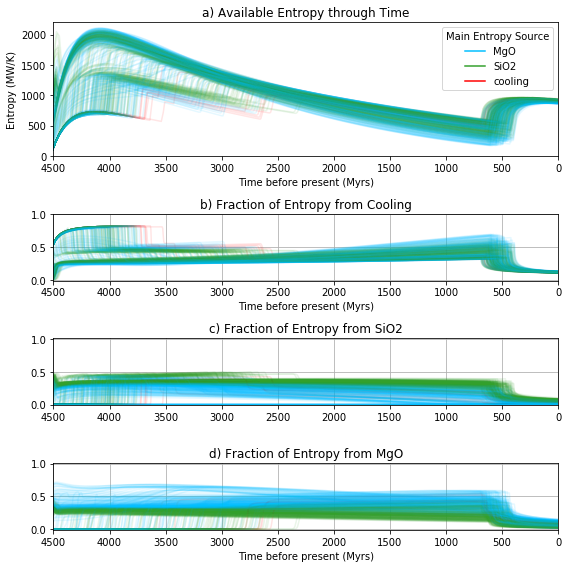

In [12]:
df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.1



plt.figure(figsize=(8,8))
# gs = gridspec.GridSpec(5, 1,height_ratios=(2,1,1,1,1)) 
gs = gridspec.GridSpec(4, 1,height_ratios=(2,1,1,1)) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
colors = []
tplts = []

for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(datadir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(datadir+foldername+solutionfile,'rb'))
        tn, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tn, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tn = tn[-1]-tn
    tp,ep = remove_outliers(tn,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    tplts.append(tn/Ct)
    Etot = allp.Ephi+allp.Ek
    Esifrac.append(allp.Egs/Etot)
    Emgfrac.append(allp.Egm/Etot)
    Efefrac.append(allp.Egf/Etot)
    Ecoolfrac.append(allp.Es/Etot)
    colors.append(color)

fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[mline,sline,coolline], title='Main Entropy Source')
plt.ylim(0,2200)
plt.xlim(4500,0)
plt.xlabel('Time before present (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
# plt.grid()

ax = plt.subplot(gs[1])
for t,e,c in zip(tplts,Ecoolfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('b) Fraction of Entropy from Cooling')
plt.grid()
plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[2])
for t,e,c in zip(tplts,Esifrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('c) Fraction of Entropy from SiO2')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[3])
for t,e,c in zip(tplts,Emgfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('d) Fraction of Entropy from MgO')
plt.grid()
plt.xlabel('Time before present (Myrs)')

# ax = plt.subplot(gs[4])
# for t,e,c in zip(tplts,Efefrac,colors):
# #     t,e = remove_outliers(t,e)
#     plt.plot(t,e,color=c,alpha=alpha)
# plt.ylim(-.01,1.01)
# plt.xlim(4500,0)
# plt.xlabel('Time before present (Myrs)')
# plt.title('Fraction of Entropy from FeO')
# plt.grid()

plt.tight_layout()
# plt.savefig('figure3_Fischer2015_SiOMgOcooling_withFeO.pdf')
plt.savefig('figure3_Fischer2015_SiOMgOcooling.pdf')

# Plot figure 4 -- version with delta-wt%

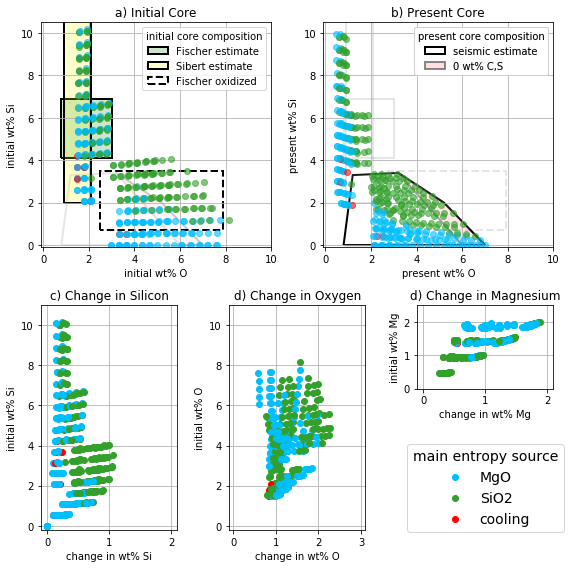

In [10]:
# Present-day constraints (Badro seismic model)
alpha = .6


df = df10.copy()
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]




ymax = 10.5
plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 6) 

ax = plt.subplot(gs[0:2,:3])

xvar = 'wt_O_0'
yvar = 'wt_Si_0'
# cvar = 'maxE'
# cvals = df[cvar].fillna('FeO')
# cnames = ['FeO','MgO','SiO2','cooling']
# cvalsn = np.array([cnames.index(v)/3 for v in cvals])
# colors = plt.cm.rainbow(cvalsn)
# colors[df[cvar].isnull()] = (1,1,1,0)
colors = maxE_color(df)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.1),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.1),fc=(1,0,0,.05))
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(0,.5,0,.2),label='Fischer estimate')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,0,.2),label='Sibert estimate')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),label='Fischer oxidized')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)

plt.legend(title='initial core composition')

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('initial wt% Si')
plt.title('a) Initial Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


ax = plt.subplot(gs[0:2,3:6])
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='seismic estimate')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.1), label='0 wt% C,S')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
leg2 = plt.legend(loc='upper right', title='present core composition')

# cnl = np.array([cnames.index(v)/3 for v in cnames])
# lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
#             label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
# leg1 = plt.legend(handles=lpatchs[1:], title='main entropy source', loc='center right')
plt.gca().add_artist(leg2)


for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('present wt% O')
plt.ylabel('present wt% Si')
plt.title('b) Present Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


ax = plt.subplot(gs[2:4,:2])
yvar = df['wt_Si_0']
xvar = yvar-df['wt_Si_p']
for x,y,c in zip(xvar,yvar,colors):
    plt.plot(x,y,'o',color=c)
plt.xlabel('change in wt% Si')
plt.ylabel('initial wt% Si')
plt.title('c) Change in Silicon')
plt.ylim(-.2,11)
plt.xlim(-.1,2.1)
plt.grid()


ax = plt.subplot(gs[2:4,2:4])
yvar = df['wt_O_0']
xvar = yvar-df['wt_O_p']
for x,y,c in zip(xvar,yvar,colors):
    plt.plot(x,y,'o',color=c)
plt.xlabel('change in wt% O')
plt.ylabel('initial wt% O')
plt.title('d) Change in Oxygen')
plt.ylim(-.2,11)
plt.xlim(-.1,3.1)
plt.grid()

ax = plt.subplot(gs[2:3,4:6])
yvar = df['wt_Mg_0']
xvar = yvar-df['wt_Mg_p']
for x,y,c in zip(xvar,yvar,colors):
    plt.plot(x,y,'o',color=c)
plt.xlabel('change in wt% Mg')
plt.ylabel('initial wt% Mg')
plt.title('d) Change in Magnesium')
plt.yticks([0,1,2])
plt.ylim(0,2.5)
plt.xlim(-.1,2.1)
plt.grid()

ax = plt.subplot(gs[3:4,4:6])
ax.axis('off')
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
leg1 = plt.legend(handles=lpatchs[1:], title='main entropy source', loc='center', fontsize=14)
plt.setp(leg1.get_title(),fontsize=14)
plt.tight_layout()
plt.savefig('figure4_deltawtp_2wtMg.pdf')

# Supplement Plots

## Fischer Cross-plot for Entropy

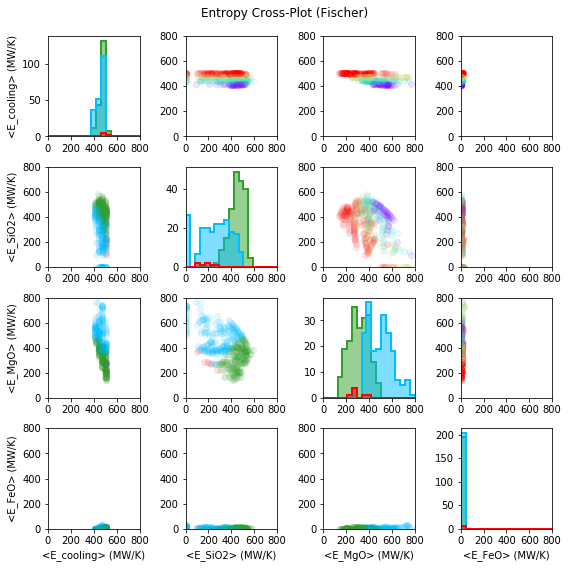

In [57]:
df = df10.copy()
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) 
ymin = 0
ymax = 800
xmin = ymin
xmax = ymax
xticks = [0,200,400,600,800]
yticks = xticks
v2plt = ['E_s_t','E_SiO2_t','E_MgO_t','E_FeO_t']
labels = ['<E_cooling> (MW/K)','<E_SiO2> (MW/K)','<E_MgO> (MW/K)','<E_FeO> (MW/K)']
for i,vy in enumerate(v2plt):
    for j,vx in enumerate(v2plt):
        ax = plt.subplot(gs[i,j])
        if i>j:
            colors = maxE_color(df)
            for x,y,c in zip(df[vx],df[vy],colors):
                plt.plot(x,y,'o',color=c,alpha=alpha)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            plt.xticks(xticks)
            plt.yticks(yticks)
        elif i<j:
            colors = df_color(df,cvar='T_cmb0')
            for x,y,c in zip(df[vx],df[vy],colors):
                plt.plot(x,y,'o',color=c,alpha=alpha)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            plt.xticks(xticks)
            plt.yticks(yticks)
        elif j==i:
            mi = np.min(df[vx])
            ma = np.max(df[vx])
            bins = np.linspace(0,800,20)
            for v in df['maxE'].unique():
                plt.hist(df[df['maxE']==v][vx],bins=bins, color=get_color(v), alpha=0.5)
                plt.hist(df[df['maxE']==v][vx],bins=bins, color=get_color(v),lw=2, histtype='step')

            plt.xlim(xmin,xmax)
#             plt.ylim(ymin,ymax)
            plt.xticks(xticks)
#                 plt.yticks(yticks)
        if j==0:
            plt.ylabel(labels[i])
        if i==3:
            plt.xlabel(labels[j])

                
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle('Entropy Cross-Plot (Fischer)')
plt.savefig('E_cross_fischer.pdf')

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


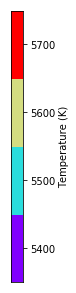

In [218]:
cvar = 'T_cmb0'    
mi = np.min(df[cvar])
ma = np.max(df[cvar])
Ts = np.linspace(mi,ma+100,(ma-mi)/100+2)
cvals = (Ts-mi)/(ma-mi)
colors= plt.cm.rainbow(cvals)
Tp = np.vstack((Ts,Ts))
cp = np.vstack((colors,colors))

plt.figure(figsize=(1,5))
plt.pcolormesh([0,1],Ts-50,Tp.T,cmap=plt.cm.rainbow)
plt.gca().yaxis.tick_right()
plt.ylim(mi-50,ma+50)
plt.xticks([])
plt.yticks(Ts[:-1])
plt.gca().yaxis.set_label_position("right")
plt.gca().set_ylabel('Temperature (K)')
plt.subplots_adjust(right=.3)
plt.savefig('Fischer_T_colorbar.pdf')


## wtp cross-plot

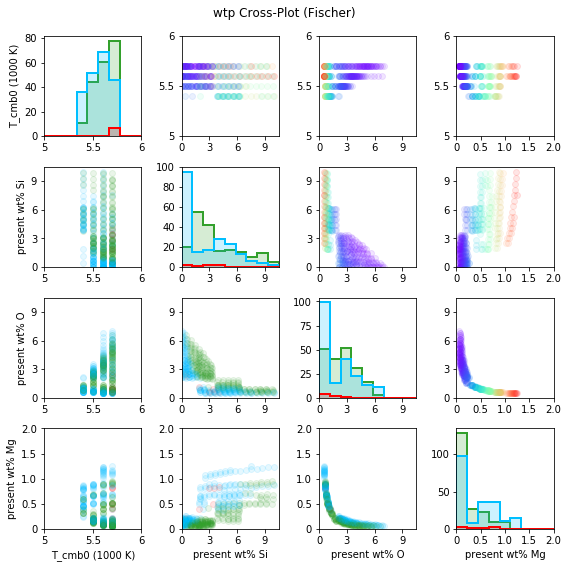

In [61]:
df = df10.copy()
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]


plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) 
mins = [5000,0,0,0]
maxs = [6000,10.5,10.5,2]
ticks = [[5000,5500,6000], [0,3,6,9],[0,3,6,9],[0,0.5,1,1.5,2]]
tickl = [[5,5.5,6],[0,3,6,9],[0,3,6,9],[0,0.5,1.0,1.5,2.0]]
v2plt = ['T_cmb0','wt_Si_p','wt_O_p','wt_Mg_p']
labels = ['T_cmb0 (1000 K)','present wt% Si','present wt% O','present wt% Mg']
for i,vy in enumerate(v2plt):
    for j,vx in enumerate(v2plt):
        xmin = mins[j]
        ymin = mins[i]
        xmax = maxs[j]
        ymax = maxs[i]
        xticks = ticks[j]
        yticks = ticks[i]
        xtl = tickl[j]
        ytl = tickl[i]
        ax = plt.subplot(gs[i,j])
        if i>j:
            colors = maxE_color(df)
            for x,y,c in zip(df[vx],df[vy],colors):
                plt.plot(x,y,'o',color=c,alpha=alpha)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            plt.xticks(xticks,xtl)
            plt.yticks(yticks,ytl)
        elif i<j:
            colors = df_color(df,cvar='wt_Mg_p')
            for x,y,c in zip(df[vx],df[vy],colors):
                plt.plot(x,y,'o',color=c,alpha=alpha)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            plt.xticks(xticks,xtl)
            plt.yticks(yticks,ytl)
        elif j==i:
            bins = np.linspace(xmin,xmax,10)
            for v in df['maxE'].unique():
                plt.hist(df[df['maxE']==v][vx],bins=bins, color=get_color(v), alpha=0.2)
                plt.hist(df[df['maxE']==v][vx],bins=bins, color=get_color(v),lw=2, histtype='step')

            plt.xlim(xmin,xmax)
            plt.xticks(xticks,xtl)
        if j==0:
            plt.ylabel(labels[i])
        if i==3:
            plt.xlabel(labels[j])

                
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle('wtp Cross-Plot (Fischer)')
plt.savefig('wtp_cross_fischer.pdf')

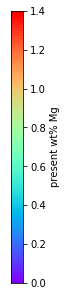

In [220]:
cvar = 'wt_Mg_p'    
mi = np.min(df[cvar])
ma = np.max(df[cvar])
Ts = np.linspace(0.,1.4,100)
cvals = (Ts-mi)/(ma-mi)
colors= plt.cm.rainbow(cvals)
Tp = np.vstack((Ts,Ts))
cp = np.vstack((colors,colors))

plt.figure(figsize=(1,5))
plt.pcolormesh([0,1],Ts,Tp.T,cmap=plt.cm.rainbow)
plt.gca().yaxis.tick_right()
# plt.ylim(4950,5750)
plt.xticks([])
plt.gca().yaxis.set_label_position("right")
plt.gca().set_ylabel('present wt% Mg')
plt.subplots_adjust(right=.3)
plt.savefig('Fischer_Mg_colorbar.pdf')


# Select Runs for Figure 2

In [77]:
dfs = df[df['maxE']=='SiO2']
dfs['smratio'] = dfs['E_SiO2_t']/dfs['E_MgO_t']
fsio2 = dfs.loc[dfs['smratio'].idxmax(),'filepath']

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
dfm = df[df['maxE']=='MgO']
dfm['smratio'] = dfm['E_SiO2_t']/dfm['E_MgO_t']
fmgo = dfm.loc[dfm['smratio'].idxmin(),'filepath']

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [79]:
dfc = df[df['maxE']=='cooling']
dfc['smratio'] = dfc['E_s_t']/(dfc['E_MgO_t']+dfc['E_SiO2_t'])
fcool = dfc.loc[dfc['smratio'].idxmax(),'filepath']

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [122]:
dfc.loc[2328]

filepath                      /media/nknezek/compute_storage/explore_space_t...
r_i                                                                 1.33155e+06
T_cmb0                                                                     5700
X_Mg_0                                                                     0.03
X_Si_0                                                                     0.06
X_O_0                                                                      0.05
wt_Mg_p                                                                 0.80602
wt_Si_p                                                                 2.99343
wt_Fe_p                                                                 90.5452
wt_O_p                                                                  0.65532
wt_MgO_p                                                                74.7462
wt_SiO2_p                                                             0.0980085
wt_FeO_p                                

In [121]:
dfc[['E_s_t','smratio']].sort_values(by='smratio')

,E_s_t,smratio
3703,504.977324,1.014678
688,504.633477,1.016293
4017,504.507720,1.024100
565,504.325106,1.034099
873,504.978469,1.076083
450,505.543222,1.087381
2328,505.545079,1.121622


In [80]:
fsio2

'/media/nknezek/compute_storage/explore_space_test/Tc5700.0_XM0.010_XS0.120_XO0.080/'

In [81]:
fmgo

'/media/nknezek/compute_storage/explore_space_test/Tc5700.0_XM0.020_XS0.000_XO0.190/'

In [82]:
fcool

'/media/nknezek/compute_storage/explore_space_test/Tc5700.0_XM0.030_XS0.060_XO0.050/'

In [112]:
# ffeo = '/media/nknezek/compute_storage/computed_solutions_nature/Tc5000.0_XM0.000_XS0.000_XO0.200/'
# ffeo = '/media/nknezek/compute_storage/computed_solutions_nature/Tc5400.0_XM0.000_XS0.020_XO0.220/'
ffeo='/media/nknezek/compute_storage/computed_solutions_nature/Tc5400.0_XM0.000_XS0.010_XO0.170/'

In [221]:
ffeo

'/media/nknezek/compute_storage/computed_solutions_nature/Tc5400.0_XM0.000_XS0.010_XO0.170/'

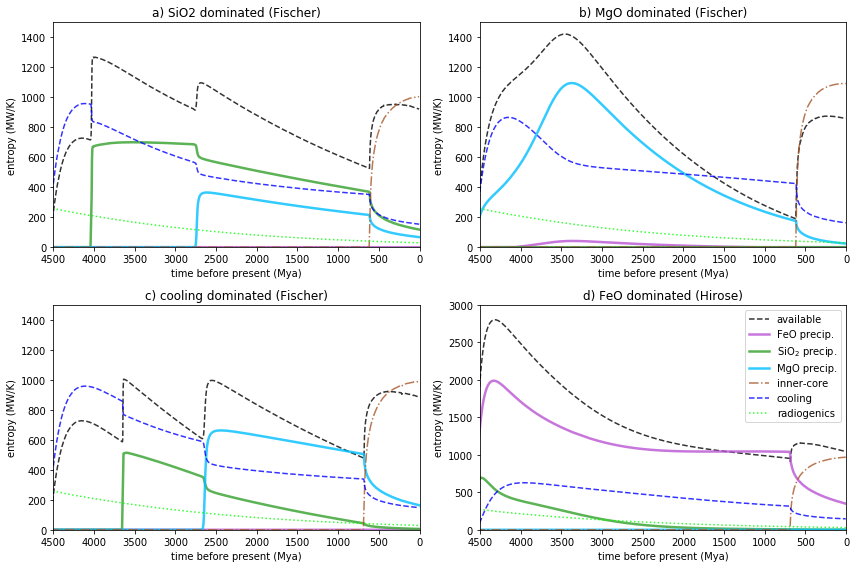

In [128]:
fstyle = '-'
mstyle = '-'
sstyle = '-'
ostyle = '-'

precip_color = 'blue'
cool_color = get_color('cooling')
fcolor = get_color('FeO')
fscolor = '#ff7f00'
mcolor = get_color('MgO')
mscolor = '#984ea3'
scolor = get_color('SiO2')
ocolor = '#ffff99'
iccolor = '#a65628'

exlw = 2.5
CE = 1e6
Emax = 1500
Emaxf = 3000
Myrs = 365.25*3600*24*1e6
xmin = 4500
xmax = 0
alpha = 0.8
fillalpha = 0.5

plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2) 

ax = plt.subplot(gs[0])
plt.title('a) SiO2 dominated (Fischer)')
folderpath = fsio2
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Efe = remove_outliers(t_plt, allp.Egf)
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)

# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
# plt.legend(loc=0)
plt.ylim(0,Emax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time before present (Mya)')

ax = plt.subplot(gs[1])
plt.title('b) MgO dominated (Fischer)')
folderpath = fmgo
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
# plt.legend(loc=0)
plt.ylim(0,Emax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time before present (Mya)')


ax = plt.subplot(gs[2])
plt.title('c) cooling dominated (Fischer)')
folderpath = fcool
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
# plt.legend(loc=0)
plt.ylim(0,Emax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time before present (Mya)')


ax = plt.subplot(gs[3])
plt.title('d) FeO dominated (Hirose)')
folderpath = ffeo
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
# plt.legend(loc=0)
plt.ylim(0,Emaxf)
plt.xlim(xmin,xmax)
plt.legend()
ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time before present (Mya)')


plt.tight_layout()
plt.savefig('figure2.pdf')

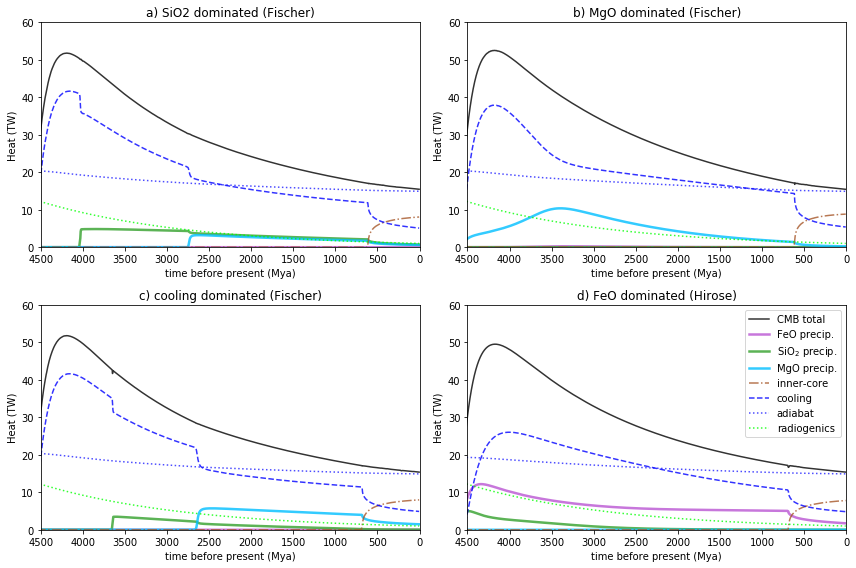

In [125]:
fstyle = '-'
mstyle = '-'
sstyle = '-'
ostyle = '-'

precip_color = 'blue'
cool_color = get_color('cooling')
fcolor = get_color('FeO')
fscolor = '#ff7f00'
mcolor = get_color('MgO')
mscolor = '#984ea3'
scolor = get_color('SiO2')
ocolor = '#ffff99'
iccolor = '#a65628'


Cq = 1e12
Qmax = 60

exlw = 2.5

Myrs = 365.25*3600*24*1e6
xmin = 4500
xmax = 0
alpha = 0.8
fillalpha = 0.5

plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2) 

ax = plt.subplot(gs[0])
plt.title('a) SiO2 dominated (Fischer)')
folderpath = fsio2
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')
plt.ylim(0,Qmax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'Heat (TW)')
ax.set_xlabel('time before present (Mya)')

ax = plt.subplot(gs[1])
plt.title('b) MgO dominated (Fischer)')
folderpath = fmgo
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')
plt.ylim(0,Qmax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'Heat (TW)')
ax.set_xlabel('time before present (Mya)')


ax = plt.subplot(gs[2])
plt.title('c) cooling dominated (Fischer)')
folderpath = fcool
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')
plt.ylim(0,Qmax)
plt.xlim(xmin,xmax)

ax.set_ylabel(r'Heat (TW)')
ax.set_xlabel('time before present (Mya)')


ax = plt.subplot(gs[3])
plt.title('d) FeO dominated (Hirose)')
folderpath = ffeo
t_plt, allp = dill.load(open(folderpath+alldatafile,'rb'))
t_plt = t_plt[-1]-t_plt

Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')
plt.ylim(0,Qmax)

plt.xlim(xmin,xmax)
plt.legend()
ax.set_ylabel(r'Heat (TW)')
ax.set_xlabel('time before present (Mya)')


plt.tight_layout()
plt.savefig('heatflow.pdf')

# Old Plots / playing with things

## Layer Composition

In [178]:
df = df10
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=2]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.1

Nrow = len(df)
ir = 0
wtp_m = np.zeros((Nrow,40000//40,5))    
X_m = np.zeros((Nrow,40000//40,5))    

for rid,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+solutionfile):
        continue
    pl, times, solution = dill.load(open(datadir+foldername+solutionfile,'rb'))
    its = np.arange(0,len(times),40)
    if ir==0:
        tplt = np.zeros((len(its)))
    for i,it in enumerate(its):
        M_c, M_m = pl.reactions.unwrap_Moles(solution[it,2:], split_coremantle=True, return_sum=False)
        wtp_m[ir,i,:] = pl.reactions.mantle.M2wtp(np.array(M_m))
        X_m[ir,i,:] = pl.reactions.mantle.M2wtp(np.array(M_m))
        if ir ==0:
            tplt[i] = times[it]
    ir +=1

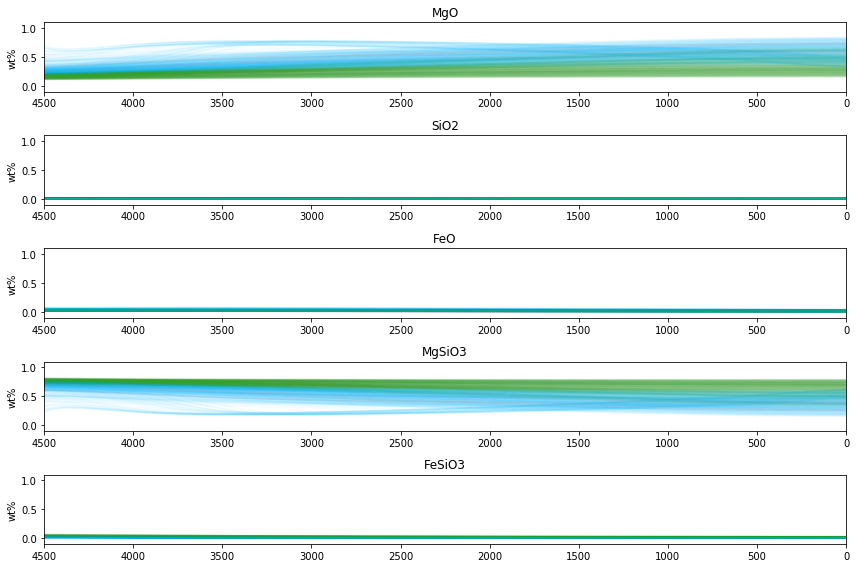

In [193]:
colors = maxE_color(df)
plt.figure(figsize=(12,8))
species = ['MgO','SiO2','FeO','MgSiO3','FeSiO3']

N = len(species)
gs = gridspec.GridSpec(N, 1) 
for i in range(N):
    ax = plt.subplot(gs[i])
    plt.xlim(4500,0)
#     plt.xlabel('Time before present (Myrs)')
    plt.title(species[i])
    for ir in range(Nrow):
        plt.plot((tplt[-1]-tplt)/Myrs, wtp_m[ir,:,i], alpha = 0.05,color=colors[ir])
    plt.ylim(-.1,1.1)
    plt.ylabel('wt%')
plt.tight_layout()
# plt.savefig('figure3_Fischer2015_SiOMgOcooling_withFeO.pdf')

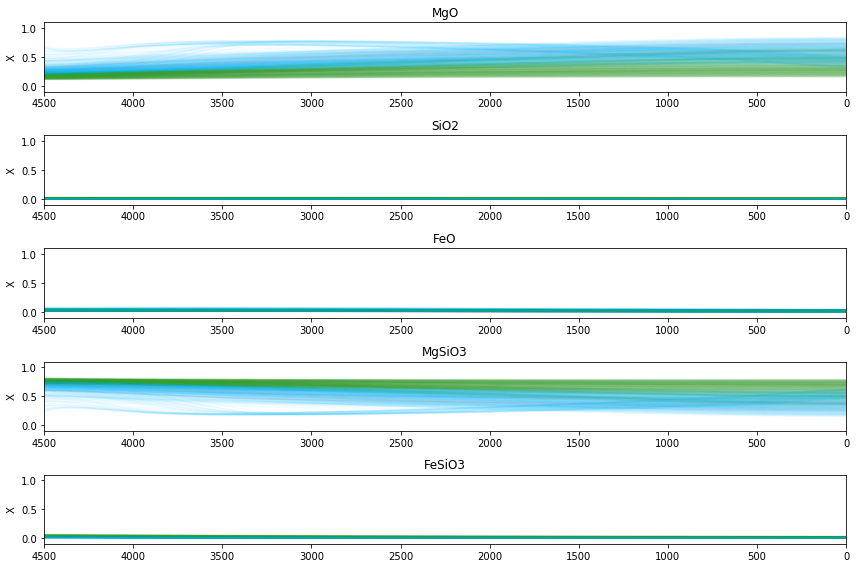

In [194]:
colors = maxE_color(df)
plt.figure(figsize=(12,8))
species = ['MgO','SiO2','FeO','MgSiO3','FeSiO3']

N = len(species)
gs = gridspec.GridSpec(N, 1) 
for i in range(N):
    ax = plt.subplot(gs[i])
    plt.xlim(4500,0)
#     plt.xlabel('Time before present (Myrs)')
    plt.title(species[i])
    for ir in range(Nrow):
        plt.plot((tplt[-1]-tplt)/Myrs, X_m[ir,:,i], alpha = 0.05,color=colors[ir])
    plt.ylim(-.1,1.1)
    plt.ylabel('X')
plt.tight_layout()
# plt.savefig('figure3_Fischer2015_SiOMgOcooling_withFeO.pdf')

Text(0.5,1,'Mg# fp')

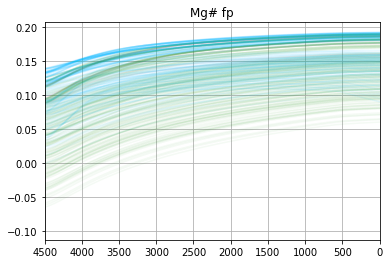

In [198]:
for ir in range(Nrow):
    Mgn_fp = X_m[ir,:,0]/(X_m[ir,:,0]+X_m[ir,:,2])
    Mgn_pv = X_m[ir,:,3]/(X_m[ir,:,3]+X_m[ir,:,4])
    plt.plot((tplt[-1]-tplt)/Myrs, Mgn_fp-.8, alpha = 0.05,color=colors[ir])
# plt.ylim(0.5,1)
plt.xlim(4500,0)
plt.grid()
plt.title('Mg# fp')

Text(0.5,1,'Mg# pv')

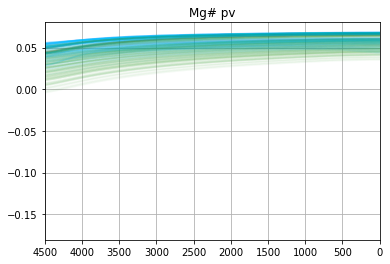

In [200]:
for ir in range(Nrow):
    Mgn_fp = X_m[ir,:,0]/(X_m[ir,:,0]+X_m[ir,:,2])
    Mgn_pv = X_m[ir,:,3]/(X_m[ir,:,3]+X_m[ir,:,4])
    plt.plot((tplt[-1]-tplt)/Myrs, Mgn_pv-.93, alpha = 0.05,color=colors[ir])
# plt.ylim(0.5,1)
plt.xlim(4500,0)
plt.grid()
plt.title('Mg# pv')

Text(0.5,1,'pv / (pv+fp)')

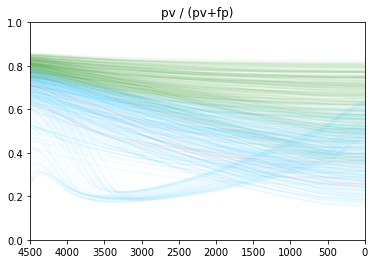

In [192]:

for ir in range(Nrow):
    fp_pv = (X_m[ir,:,3]+X_m[ir,:,4])/(X_m[ir,:,3]+X_m[ir,:,4]+X_m[ir,:,0]+X_m[ir,:,2])
    plt.plot((tplt[-1]-tplt)/Myrs, fp_pv, alpha = 0.05,color=colors[ir])
plt.ylim(0,1)
plt.xlim(4500,0)
plt.title('pv / (pv+fp)')

Text(0.5,1,'X_pv')

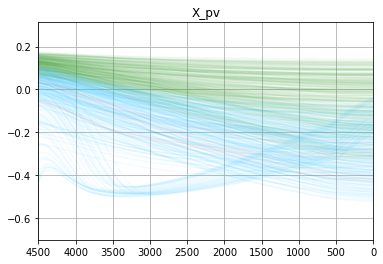

In [204]:

for ir in range(Nrow):
    fp_pv = (X_m[ir,:,3]+X_m[ir,:,4])
    plt.plot((tplt[-1]-tplt)/Myrs, fp_pv-.674, alpha = 0.05,color=colors[ir])
# plt.ylim(0,1)
plt.xlim(4500,0)
plt.grid()
plt.title('X_pv')

# Plot figure 4 -- 4 panel core composition

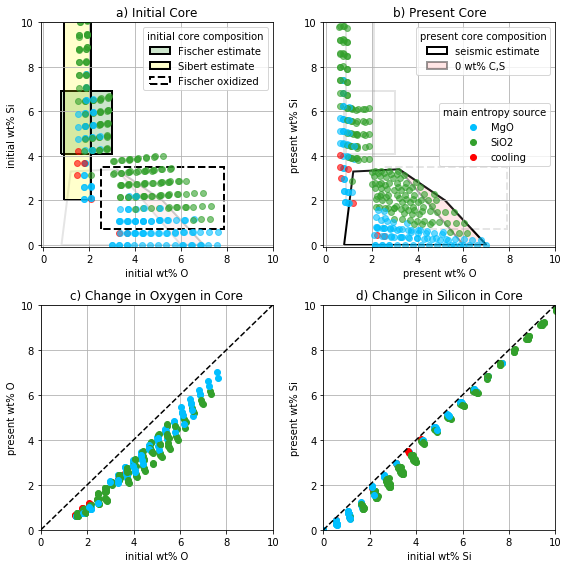

In [138]:
# Present-day constraints (Badro seismic model)
alpha = .6


df = df10.copy()
df = df[df['wt_O_p']<=10]
# df = df[df['wt_O_p']<=df['wt_O_0']]
df = df[df['wt_Si_p']<=10]
df = df[df['T_cmb0']<=5700]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]




ymax = 10
plt.figure(figsize=(8,8))
ax = plt.subplot(221)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
# cvar = 'maxE'
# cvals = df[cvar].fillna('FeO')
# cnames = ['FeO','MgO','SiO2','cooling']
# cvalsn = np.array([cnames.index(v)/3 for v in cvals])
# colors = plt.cm.rainbow(cvalsn)
# colors[df[cvar].isnull()] = (1,1,1,0)
colors = maxE_color(df)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.1),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.1),fc=(1,0,0,.05))
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(0,.5,0,.2),label='Fischer estimate')
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,0,.2),label='Sibert estimate')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),label='Fischer oxidized')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)

plt.legend(title='initial core composition')

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('initial wt% Si')
plt.title('a) Initial Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


ax = plt.subplot(222)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='seismic estimate')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSinoCSPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,0,0,.1), label='0 wt% C,S')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., ec=(0,0,0,1), fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
patch = patches.PathPatch(SiebertOSiPath, lw=2., ec=(0,0,0,1), fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0),alpha=.1)
ax.add_patch(patch)
leg2 = plt.legend(loc='upper right', title='present core composition')

cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
leg1 = plt.legend(handles=lpatchs[1:], title='main entropy source', loc='center right')
plt.gca().add_artist(leg2)


for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('present wt% O')
plt.ylabel('present wt% Si')
plt.title('b) Present Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()


plt.subplot(223)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('present wt% O')
plt.title('c) Change in Oxygen in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()


plt.subplot(224)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% Si')
plt.ylabel('present wt% Si')
plt.title('d) Change in Silicon in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.tight_layout()
plt.savefig('Core_composition_initfinal_4panel_OxidizedAndPreferred_Fischer2015.pdf')

(0, 4)

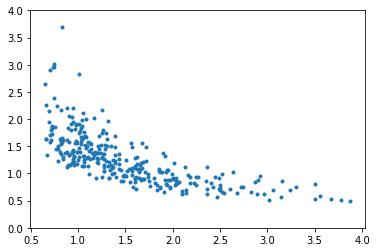

In [542]:
plt.plot(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],'.')
plt.ylim(0,4)

In [544]:
# cvals = (df10['T_cmb0']-5000)/1000
cvals = (df10['X_Mg_0'])/.04
colors= plt.cm.rainbow(cvals)

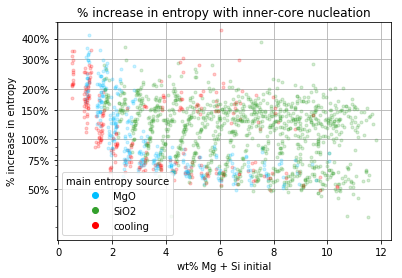

In [679]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_MgSi_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Mg + Si initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpMgSi_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

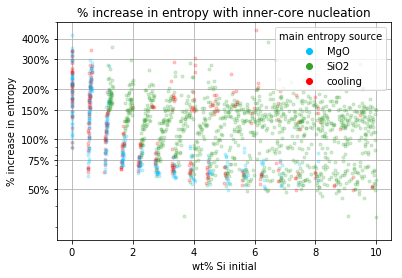

In [681]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_Si_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Si initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpSi_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

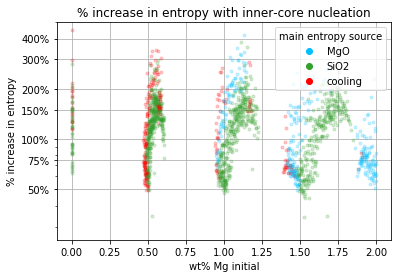

In [682]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['wt_Mg_0'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('wt% Mg initial')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('wtpMg_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

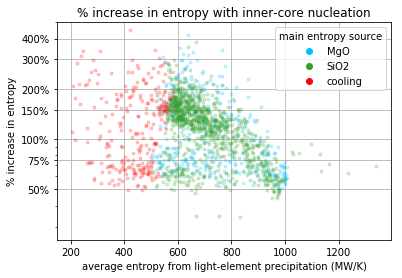

In [670]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropy_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

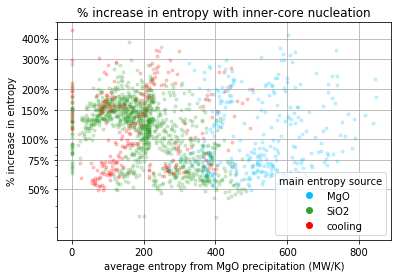

In [674]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_MgO_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from MgO precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropyMgO_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

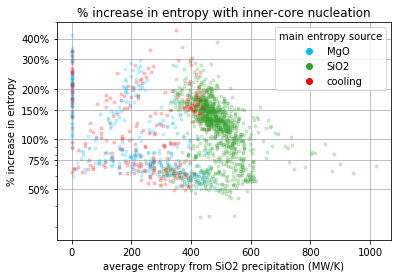

In [677]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_SiO2_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from SiO2 precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropySiO2_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

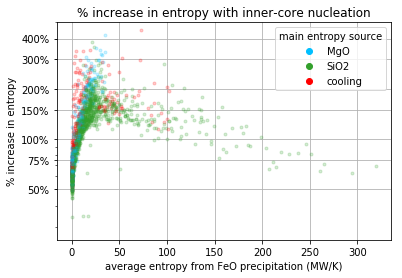

In [678]:
df = df10[df10['wt_Mg_0']<2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_FeO_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=0.2)
plt.xlabel('average entropy from FeO precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source')
plt.savefig('entropyFeO_vs_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

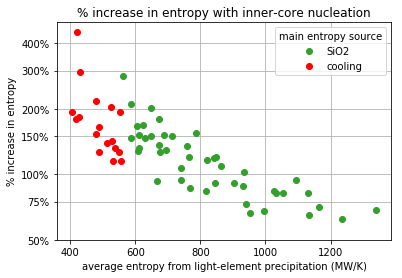

In [659]:
# plt.close('all')
df = df10[df10['wt_Mg_0']<.2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)

for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    if y>0:
        plt.plot(x,np.log(y*100),'o',color=c)

plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
plt.legend(handles=lpatchs[2:], title='main entropy source')
plt.grid()
yticks = [50,75,100,150,200, 300,400]
plt.yticks(np.log(yticks),['{:.0f}%'.format(x) for x in yticks])
plt.ylim(np.log(50),np.log(500))
plt.savefig('entropy_vs_ic_Fischer_noMg.pdf')


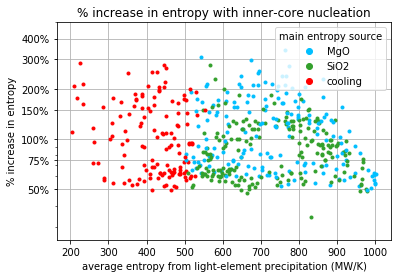

In [52]:
df = df10[df10['wt_Mg_0']<=2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]

# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)]
# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)| (df['in_SiebertOSiPath']==True)]
df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(df['E_ex_t'],df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('average entropy from light-element precipitation (MW/K)')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)

plt.legend(handles=lpatchs[1:], title='main entropy source',)
plt.savefig('entropy_vs_ic_Fischer_SeismicConstraint.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

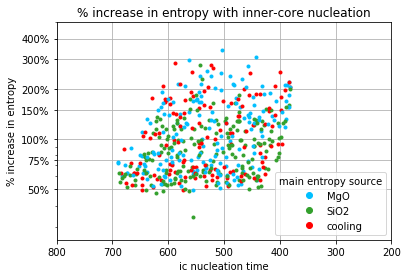

In [61]:
df = df10[df10['wt_Mg_0']<=2]
df = df[df['wt_O_0']<12]
df = df[df['wt_Si_0']<10]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_SiebertOSiPath'] = SiebertOSiPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]

# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)]
# df = df[(df['in_FischerReferenceInitial']==True) | (df['in_BadroSeismicPresent']==True)| (df['in_SiebertOSiPath']==True)]
df = df[(df['in_FischerReferenceInitial']==True) | ((df['in_BadroSeismicPresent']==True) & (df['wt_O_p']>=2.))| (df['in_SiebertOSiPath']==True)]

# df = df[df['in_BadroSeismicPresent']==True]
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
colors = maxE_color(df)
for x,y,c in zip(4560-df['t_ic']/Myrs,df['dE_ic'],colors):
    plt.semilogy(x,y*100,'.',color=c,alpha=1)
plt.xlabel('ic nucleation time')
plt.ylabel('% increase in entropy')
plt.title('% increase in entropy with inner-core nucleation')
yticks = [50,75,100,150,200, 300,400]
plt.yticks(yticks,['{:.0f}%'.format(x) for x in yticks])
plt.grid()
plt.ylim(25,500)
plt.xlim(800,200)
plt.legend(handles=lpatchs[1:], title='main entropy source',)
plt.savefig('entropy_jump_ic_vs_time_ic_Fischer.pdf')
# plt.ylim(0,4)
# plt.xlim(0,1500)

(0, 4)

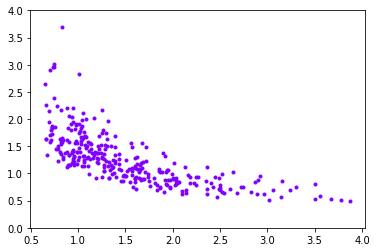

In [546]:
for x,y,c in zip(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

(0, 5)

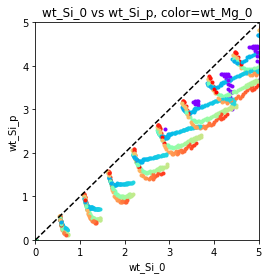

In [301]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

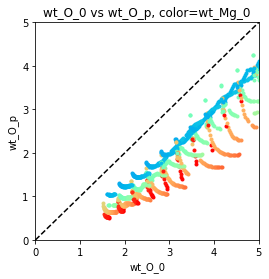

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
